# A sanity check for the distribution of "conformal p-values" in testing randomness/exchangeability

Given binary data points $X_1, X_2, ...$, consider the null
$$
\mathcal{H}_0^{iid}: \text{$X_1, X_2, ...$ are i.i.d.}
$$

Vovk (2003; 2021)'s conformal test martingale is defined as 
$$
M_t(\lambda) = \prod_{i=1}^t \left[ 1 + \lambda \left( s_i - \frac{1}{2}\right) \right],
$$
where $s_1, ..., s_t$ are "conformal p-values". They satisfy that:
$$
\text{Under $\mathcal{H}_0^{iid}$,   $s_1, ..., s_t \overset{iid}{\sim} \mathrm{Unif}[0,1]$,}
$$
as p-values would; nevertheless, they are not p-values in the traditional sense because smaller _or_ larger values of $s_t$ can indicate evidence against the i.i.d. null.

For each $t$, the conformal p-value $s_t$ is defined as
$$
s_t = \frac{1}{t} \left[ \#\{i \leq t: \alpha_i > \alpha_t\} + U_t \cdot \#\{i \leq t: \alpha_i = \alpha_t\} \right],
$$
where $U_t \sim \mathrm{Unif}[0,1]$ is an independent Uniform r.v. and each $\alpha_t = \mathcal{A}(X_t; \{X_1, ..., X_t\})$ is a _nonconformity score_ measuring how "strange" $X_t$ relative to the data $\{X_1, ..., X_t\}$.

For IID/randomness testing of binary sequences, Vovk suggests using the identity nonconformity score: 
$$
\alpha_t = X_t.
$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import os

import ecombine as ec

In [2]:
# basic figure styles
ec.set_theme()

# rng for data generation and inference methods, separately
rng_data = np.random.default_rng(20250205)
rng = np.random.default_rng(50205202)

# plots saved here
plots_dir = "./plots/exch/conformal_sanity_check"
os.makedirs(plots_dir, exist_ok=True)
mpl.rc("savefig", format="png", dpi=350)

colors = sns.color_palette("colorblind")

## 1. The IID Case

Given $X_1, ..., X_T$, we can draw the histogram of $s_1, ..., s_T$ to check if it is actually IID $\mathsf{Unif}[0,1]$.

Note again that the "nonconformity score" is simply the identity function, that is, $\alpha_t = X_t$ for each $t$.

In [3]:
# max seq size
T = 1000

# n repeated trials
n_trials = 10

In [4]:
def get_conformal_pvalues_under_iid(T, p=0.5, rng=None, rng_data=None):
    """Compute conformal p-values under IID Bernoulli(p) for T steps."""
    x = ec.data.exch.generate_binary_iid(p=p, size=T, rng=rng_data)
    s = ec.precompute_conformal_pvalues(x, rng=rng)
    return s

We'll plot histograms for different values of $p$: 0.5, 0.2, 0.9.

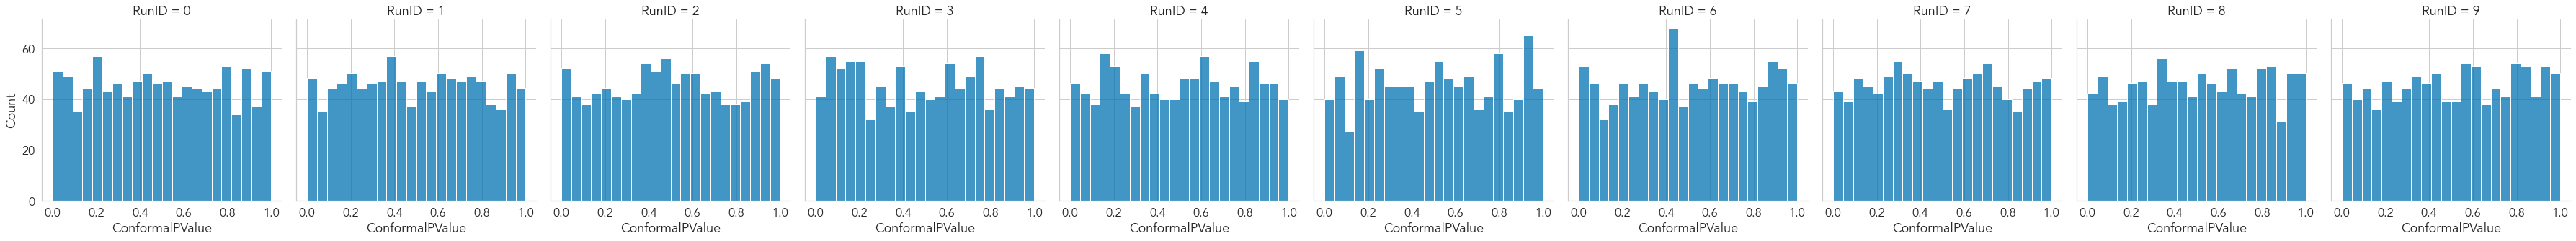

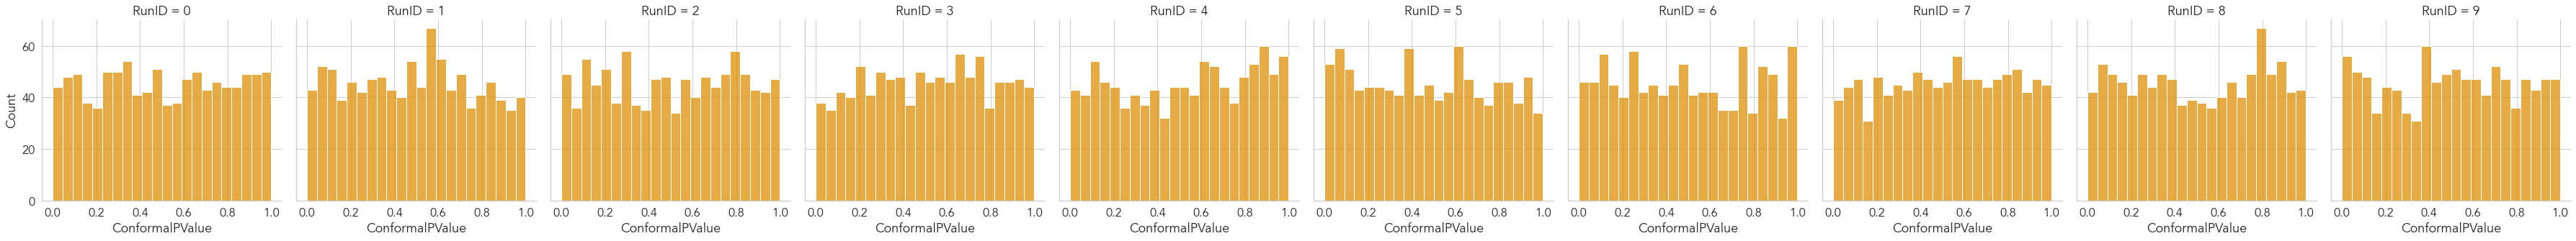

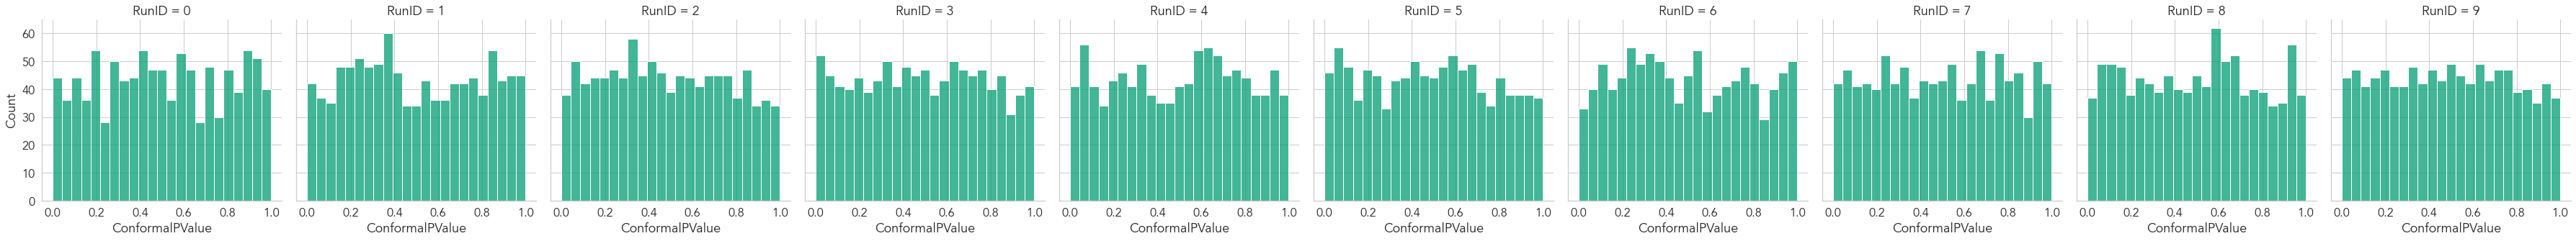

In [5]:
ps = [0.5, 0.2, 0.9]
for p, color in zip(ps, colors):
    data = []
    times = np.arange(1, T + 1)
    # generate data n_trials times
    for i in range(n_trials):
        s = get_conformal_pvalues_under_iid(
            T, p=p, rng=rng, rng_data=rng_data)
        data.append(pd.DataFrame(
            {"RunID": i, "Time": times, "ConformalPValue": s}))
    data = pd.concat(data, axis=0)
    # plot
    fg = sns.displot(
        data=data,
        x="ConformalPValue",
        col="RunID",
        color=color,
    )
    fg.tight_layout()
    fg.savefig(os.path.join(plots_dir, 
                            f"ConformalPValuesHistIID{p}.png"), dpi=350)

## 2. Changepoint from $\mathrm{Ber}(p)$ to $\mathrm{Ber}(p+\delta)$

Next, we consider data from a changepoint alternative where the mean increases after $\lfloor \frac{T}{2} \rfloor$ steps.

We fix $p=0.8$ and try different values of $\delta \in \{0.0, 0.2, 0.4, 0.6, 0.8\}$.

**As $\delta$ increases, the conformal "p-values" skew towards 0 (also see item 3 below).**

In [6]:
def get_conformal_pvalues_under_change(
        T, p=0.5, q=0.5,
        change_loc=0.5,  # change at half of T
        rng=None, rng_data=None
        ):
    """Compute conformal p-values under IID Bernoulli(p) for T steps."""
    x = ec.data.exch.generate_binary_changepoint(
        p=p, q=q, size=T, change_loc=change_loc, rng=rng_data)
    s = ec.precompute_conformal_pvalues(x, rng=rng)
    return s

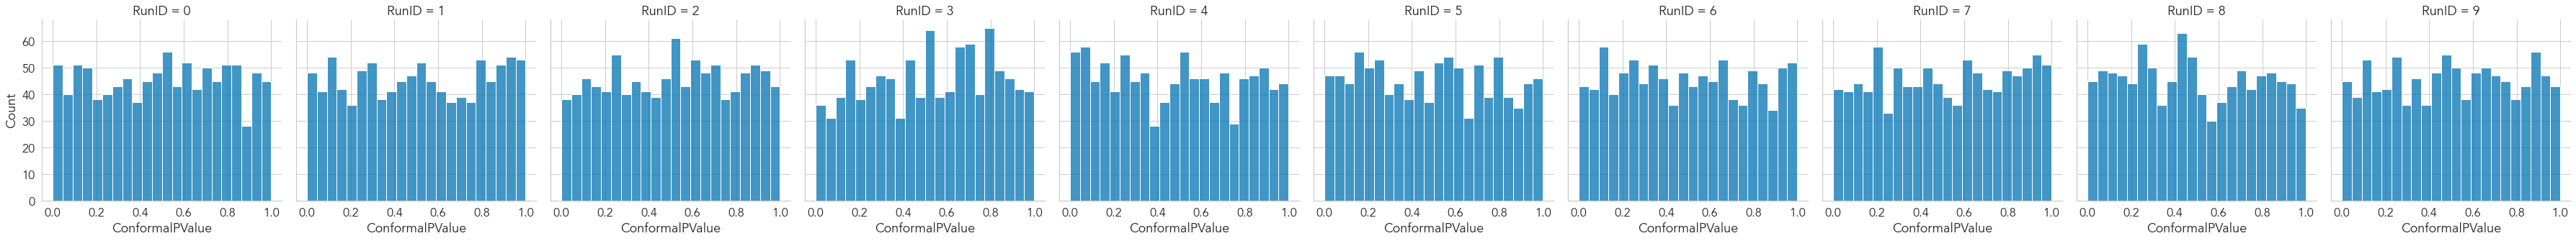

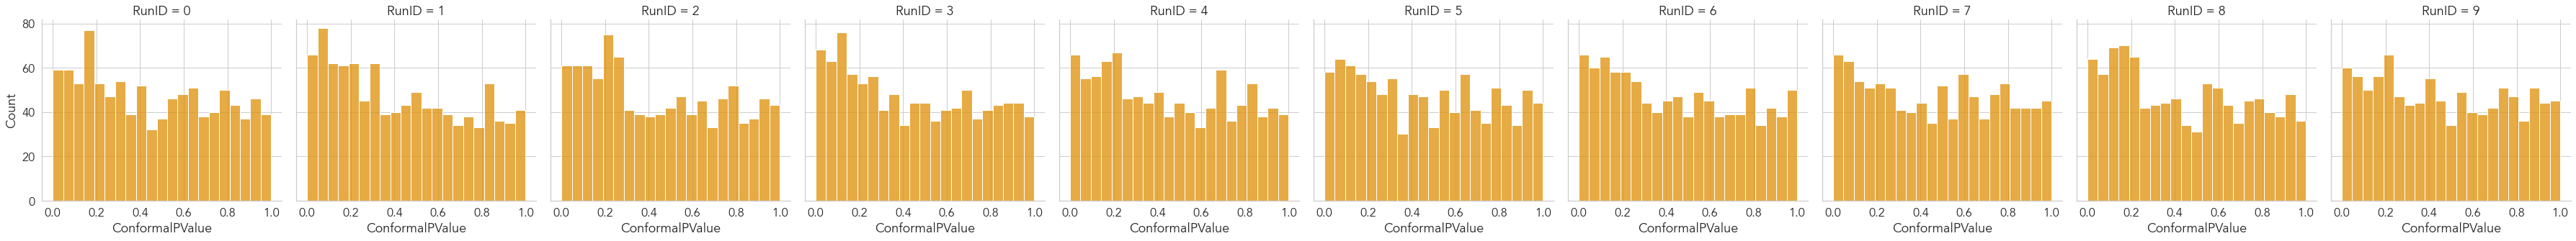

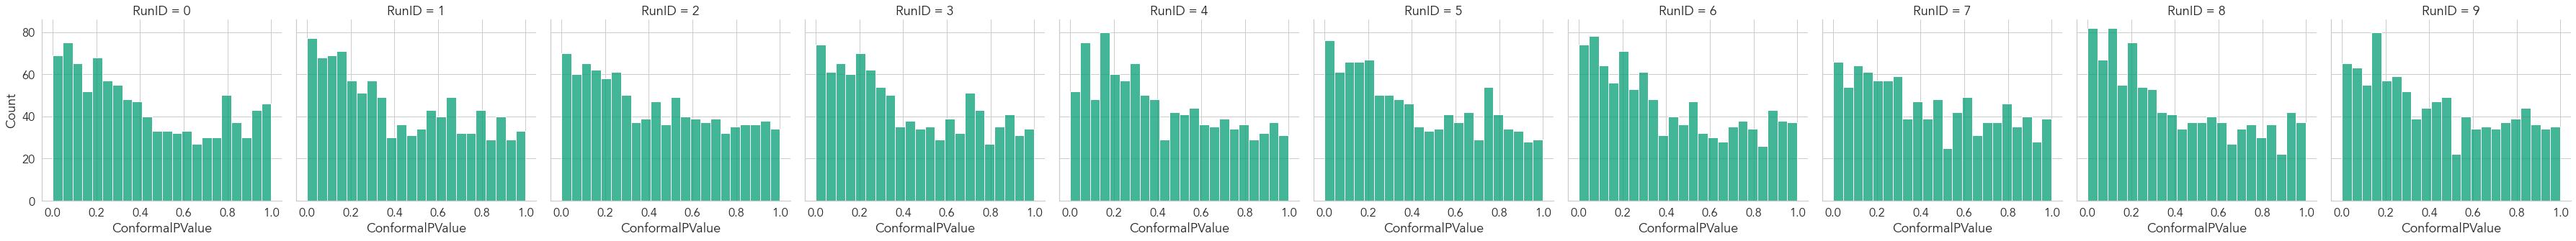

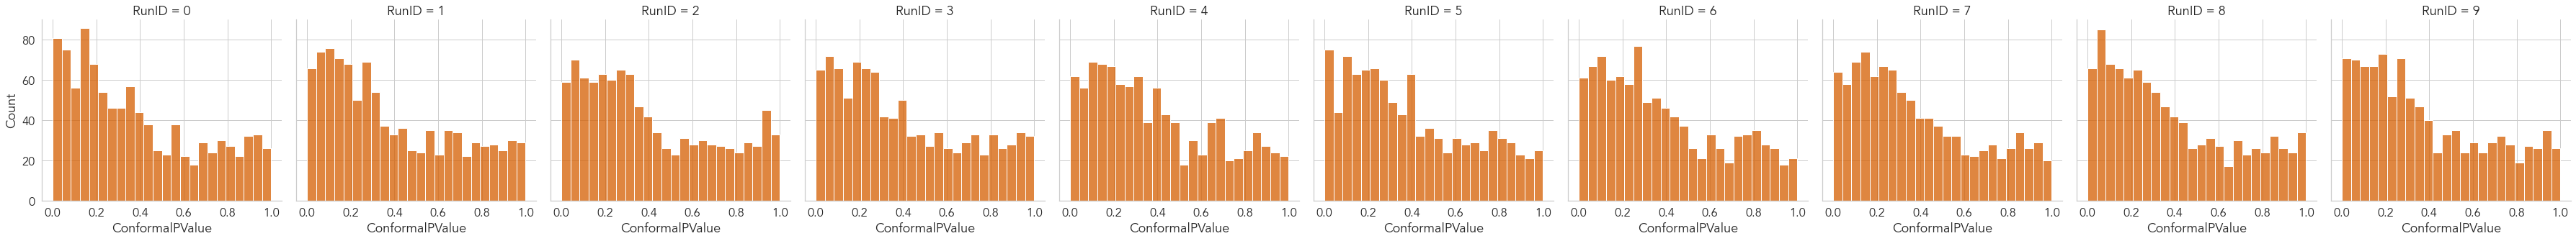

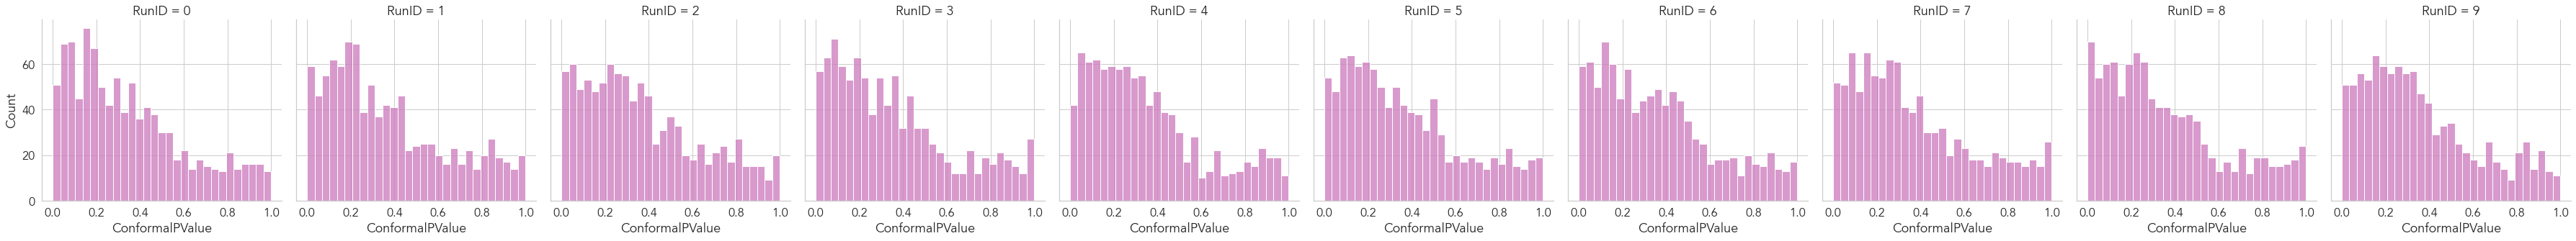

In [7]:
p = 0.2
deltas = [0.0, 0.2, 0.4, 0.6, 0.8]
increase = True
for delta, color in zip(deltas, colors):
    q = p + delta if increase else p - delta
    data = []
    times = np.arange(1, T + 1)
    # generate data n_trials times
    for i in range(n_trials):
        s = get_conformal_pvalues_under_change(
            T, p=p, q=q, rng=rng, rng_data=rng_data)
        data.append(pd.DataFrame(
            {"RunID": i, "Time": times, "ConformalPValue": s}))
    data = pd.concat(data, axis=0)
    # plot
    fg = sns.displot(
        data=data,
        x="ConformalPValue",
        col="RunID",
        color=color,
    )
    fg.tight_layout()
    fg.savefig(os.path.join(plots_dir, 
                            f"ConformalPValuesHistChange({p},{q}).png"), 
               dpi=350)

## 3. Changepoint from $\mathrm{Ber}(p)$ to $\mathrm{Ber}(p-\delta)$

The final case is a changepoint alternative where the mean _decreases_ after $\lfloor \frac{T}{2} \rfloor$ steps.

We fix $p=0.8$ and try different values of $\delta \in \{0.0, 0.2, 0.4, 0.6, 0.8\}$.

**As $\delta$ increases, the conformal "p-values" skew towards 1 (this is why they're not actually p-values in the traditional sense).**

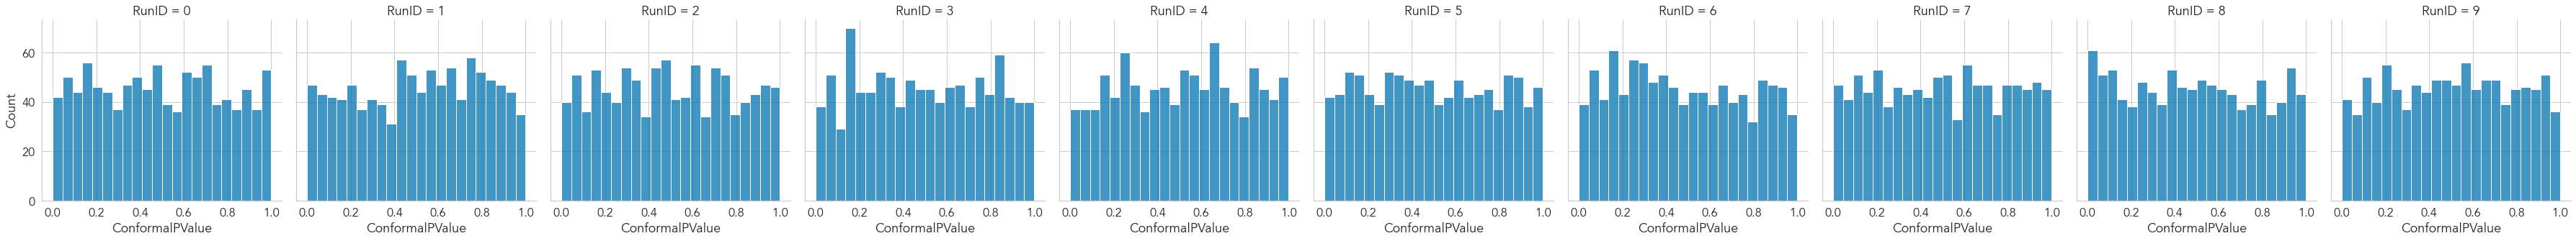

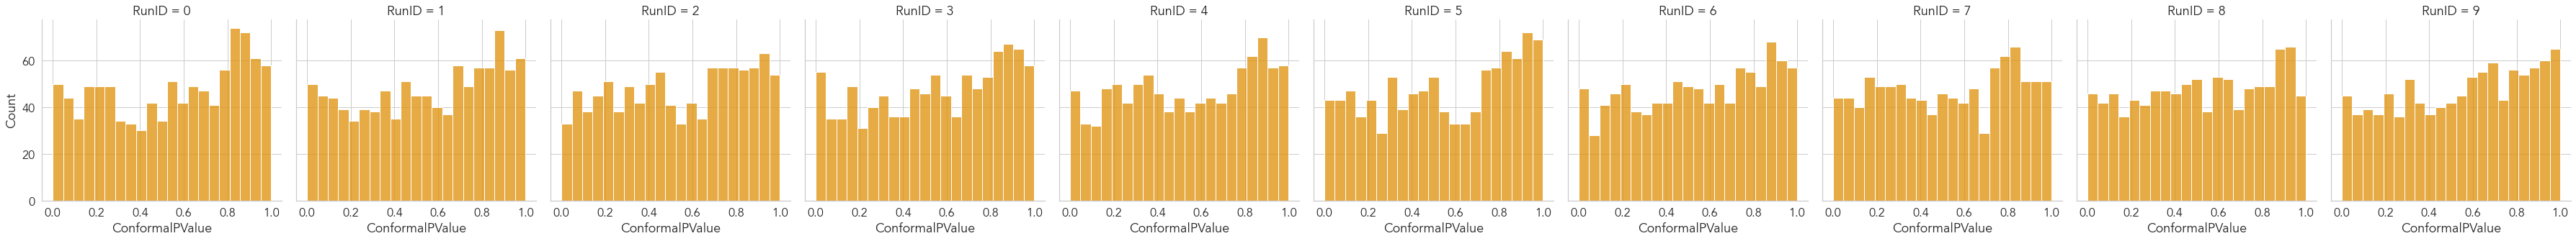

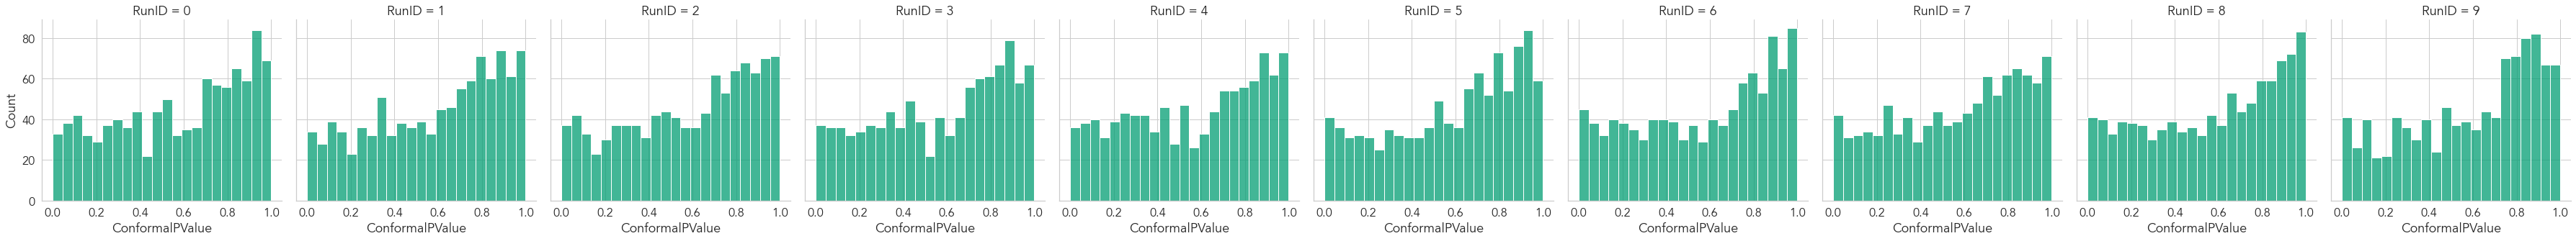

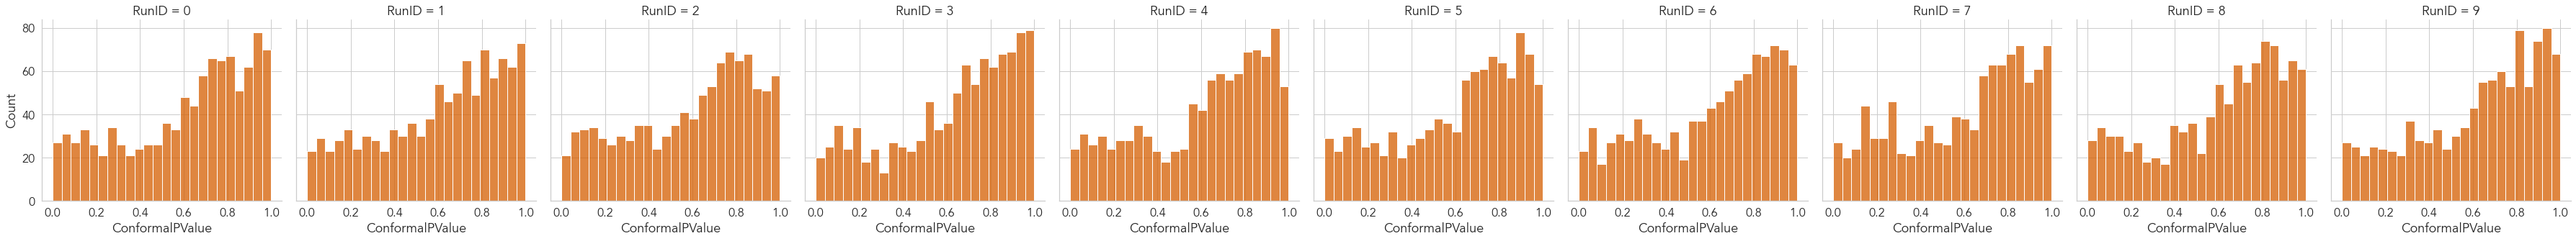

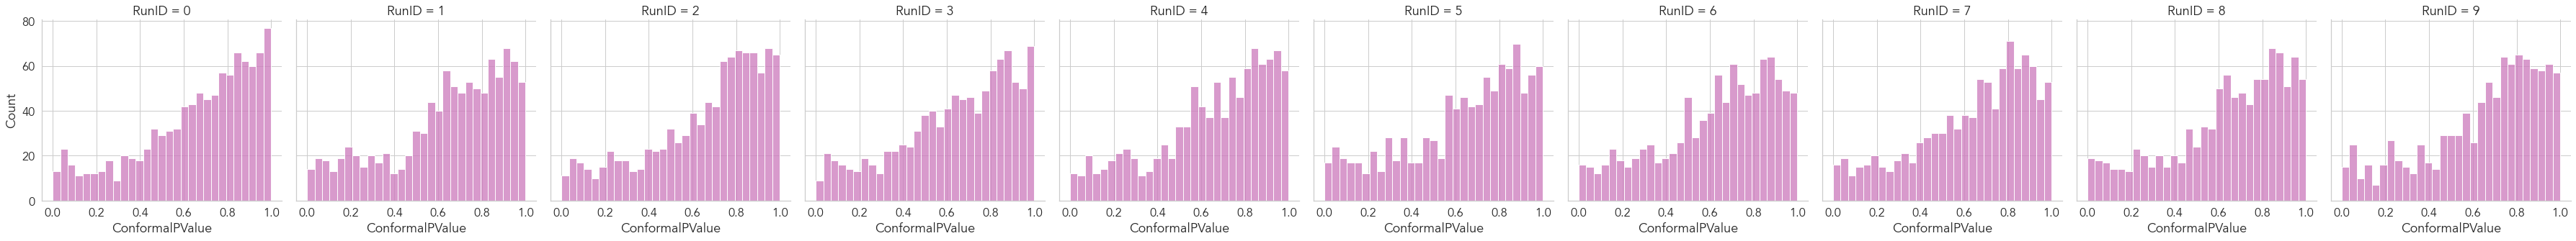

In [8]:
p = 0.8
deltas = [0.0, 0.2, 0.4, 0.6, 0.8]
increase = False
for delta, color in zip(deltas, colors):
    q = p + delta if increase else p - delta
    data = []
    times = np.arange(1, T + 1)
    # generate data n_trials times
    for i in range(n_trials):
        s = get_conformal_pvalues_under_change(
            T, p=p, q=q, rng=rng, rng_data=rng_data)
        data.append(pd.DataFrame(
            {"RunID": i, "Time": times, "ConformalPValue": s}))
    data = pd.concat(data, axis=0)
    # plot
    fg = sns.displot(
        data=data,
        x="ConformalPValue",
        col="RunID",
        color=color,
    )
    fg.tight_layout()
    fg.savefig(os.path.join(plots_dir, 
                            f"ConformalPValuesHistChange({p},{q}).png"), 
               dpi=350)